In [92]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from typing import TypedDict

import numpy as np
from temgymbasic import components as comp
from temgymbasic.model import Model
from temgymbasic.functions import get_pixel_coords
from temgym_proto import STEMModel, DoubleDeflector
import numba
%matplotlib ipympl



In [94]:
class OverfocusParams(TypedDict):
    overfocus: float  # m
    scan_pixel_size: float  # m
    camera_length: float  # m
    detector_pixel_size: float  # m
    semiconv: float  # rad
    cy: float
    cx: float
    scan_rotation: float
    flip_y: bool



In [95]:
def make_model(params: OverfocusParams, dataset_shape):
    # We have to make it square
    sample = np.ones((dataset_shape[0], dataset_shape[0]))
    
    # Create a list of components to model a simplified 4DSTEM experiment
    components = [
        comp.DoubleDeflector(name='Scan Coils', z_up=0.3, z_low=0.25),
        comp.Lens(name='Lens', z=0.20),
        comp.Sample(
            name='Sample',
            sample=sample,
            z=params['camera_length'],
            width=sample.shape[0] * params['scan_pixel_size']
        ),
        comp.DoubleDeflector(
            name='Descan Coils',
            z_up=0.1,
            z_low=0.05,
            scan_rotation=0.
        )
    ]

    # Create the model Electron microscope. Initially we create a parallel
    # circular beam leaving the "gun"
    model = Model(
        components,
        beam_z=0.4,
        beam_type='paralell',
        num_rays=7,  # somehow the minimum
        experiment='4DSTEM',
        detector_pixels=dataset_shape[1],
        detector_size=dataset_shape[1] * params['detector_pixel_size'],
    )
    model.set_obj_lens_f_from_overfocus(params['overfocus'])
    model.scan_pixels = dataset_shape[0]
    return model

def make_model_proto(params: OverfocusParams, dataset_shape):
    sample = np.ones((dataset_shape[0], dataset_shape[1]))
    model = STEMModel(
        camera_length=params['camera_length'],
        semiconv_angle=params['semiconv'],
        scan_step_yx=(params['scan_pixel_size'], params['scan_pixel_size']),
        scan_shape=(sample.shape[0], sample.shape[1]),
        scan_rotation=params['scan_rotation'],
        flip_y=params['flip_y'],
        overfocus=params['overfocus'],
        detector_z=0.4
    )
    return model

In [96]:
def get_translation_matrix(params: OverfocusParams, model):
    a = []
    b = []
    model.scan_pixel_x = 0
    model.scan_pixel_y = 0
    for scan_y in (0, model.scan_pixels - 1):
        for scan_x in (0, model.scan_pixels - 1):
            model.scan_pixel_y = scan_y
            model.scan_pixel_x = scan_x
            model.update_scan_coil_ratio()
            model.step()
            sample_rays_x = model.r[model.sample_r_idx, 0, :]
            sample_rays_y = model.r[model.sample_r_idx, 2, :]
            detector_rays_x = model.r[-1, 0, :]
            detector_rays_y = model.r[-1, 2, :]
            sample_coords_x, sample_coords_y = get_pixel_coords(
                rays_x=sample_rays_x,
                rays_y=sample_rays_y,
                size=model.components[model.sample_idx].sample_size,
                pixels=model.components[model.sample_idx].sample_pixels,
            )
            detector_coords_x, detector_coords_y = get_pixel_coords(
                rays_x=detector_rays_x,
                rays_y=detector_rays_y,
                size=model.detector_size,
                pixels=model.detector_pixels,
                flip_y=params['flip_y'],
                scan_rotation=params['scan_rotation'],
            )
            for i in range(len(sample_coords_x)):
                a.append((
                    sample_coords_y[i],
                    sample_coords_x[i],
                    model.scan_pixel_y,
                    model.scan_pixel_x,
                    1
                ))
                b.append((detector_coords_y[i], detector_coords_x[i]))
    res = np.linalg.lstsq(a, b, rcond=None)
    return res[0]

def get_translation_matrix_proto(params: OverfocusParams, model):
    yxs = ((0, 0), (model.sample.scan_shape[0], model.sample.scan_shape[1]), (0, model.sample.scan_shape[1]))
    num_rays = 5
    
    detector_idx = -1
    sample_idx = 4

    a=[]
    b=[]

    for yx in yxs:
        rays=tuple(model.scan_point_iter(num_rays=num_rays, yx=yx))
        detector_rays=rays[detector_idx]
        sample_rays=rays[sample_idx]

        for i in range(len(detector_rays.x)):
            b.append((detector_rays.y[i], detector_rays.x[i]))
        
        for i in range(len(sample_rays.x)):
            a.append((
                sample_rays.y[i],
                sample_rays.x[i],
                model.sample.scan_shape[0]-yx[0],
                model.sample.scan_shape[1]-yx[1],
                1
            ))

    print(np.array(a).shape, np.array(b).shape)
    print(np.array(b), np.array(b).shape)
    res = np.linalg.lstsq(a, b, rcond=None)

    return res[0]


In [97]:
def plot_rays(model):
        # Iterate over components and their ray positions
    num_rays = 3
    yx = (0, 128)
    all_rays = tuple(model.scan_point_iter(num_rays=num_rays, yx=yx))

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    xvals = np.stack(tuple(r.x for r in all_rays), axis=0)
    zvals = np.asarray(tuple(r.z for r in all_rays))
    ax.plot(xvals, zvals)

    # Optional: Mark the component positions
    extent = 1.5 * np.abs(xvals).max()
    for component in model.components:
        if isinstance(component, DoubleDeflector):
            ax.hlines(
                component.first.z, -extent, extent, linestyle='--'
            )
            ax.text(-extent, component.first.z, repr(component.first), va='bottom')
            ax.hlines(
                component.second.z, -extent, extent, linestyle='--'
            )
            ax.text(-extent, component.second.z, repr(component.second), va='bottom')
        else:
            ax.hlines(component.z, -extent, extent, label=repr(component))
            ax.text(-extent, component.z, repr(component), va='bottom')

    ax.hlines(
        model.objective.ffp, -extent, extent, linestyle=':'
    )

    ax.axvline(color='black', linestyle=":", alpha=0.3)
    _, scan_pos_x = model.sample.scan_position(yx)
    ax.plot([scan_pos_x], [model.sample.z], 'ko')

    ax.set_xlabel('x position')
    ax.set_ylabel('z position')
    ax.invert_yaxis()
    ax.set_title(f'Ray paths for {num_rays} rays at position {yx}')
    plt.show()


(15, 5) (15, 2)
[[-3.10862447e-17 -3.10862447e-17]
 [-3.10862447e-17 -8.42869076e-02]
 [-8.42869076e-02 -3.10862447e-17]
 [-3.10862447e-17  8.42869076e-02]
 [ 8.42869076e-02 -3.10862447e-17]
 [ 3.10862447e-17  3.10862447e-17]
 [ 3.10862447e-17 -8.42869076e-02]
 [-8.42869076e-02  3.10862447e-17]
 [ 3.10862447e-17  8.42869076e-02]
 [ 8.42869076e-02  3.10862447e-17]
 [-3.10862447e-17  3.10862447e-17]
 [-3.10862447e-17 -8.42869076e-02]
 [-8.42869076e-02  3.10862447e-17]
 [-3.10862447e-17  8.42869076e-02]
 [ 8.42869076e-02  3.10862447e-17]] (15, 2)


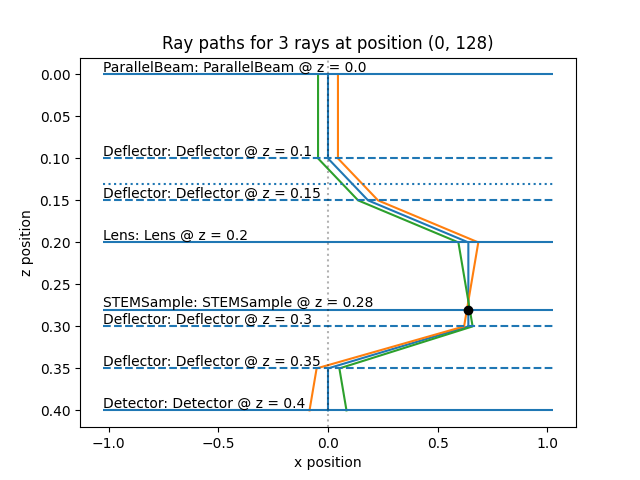

[[-2.60000000e+01 -3.90970803e-12]
 [ 2.70006240e-13  2.60000000e+01]
 [-5.80000000e+01 -9.70197351e-12]
 [ 7.88914992e-13  5.80000000e+01]
 [ 5.38400000e+03 -5.25800000e+03]] 

 [[ 1.30000000e+01 -6.72899134e-13]
 [ 4.74759121e-14  1.30000000e+01]
 [ 1.30000000e-01  2.16996138e-15]
 [ 5.37826903e-16  1.30000000e-01]
 [-8.32000000e+00 -8.32000000e+00]]


In [98]:
    dataset_shape = [128, 128]
    overfocus_params = OverfocusParams(
        overfocus=0.01,  # m
        scan_pixel_size=0.01,  # m
        camera_length=0.12,  # m
        detector_pixel_size=0.0050,  # m
        semiconv=10,  # rad
        scan_rotation=0,
        flip_y=False,
        # Offset to avoid subchip gap
        cy=128,
        cx=128,
    )
    
    model = make_model(overfocus_params, dataset_shape)
    model_proto = make_model_proto(overfocus_params, dataset_shape)
    res = get_translation_matrix(overfocus_params, model)
    res_proto = get_translation_matrix_proto(overfocus_params, model_proto)
    plot_rays(model_proto)
    print(res, '\n\n', res_proto)